# Kernel Density Estimation for Wekas in the Marlborough Sounds

This notebook sets up a QGIS KDE plot of Weka observations, using field data kindly provided by Graeme Elliot & the Threats Science Team at the [Department of Conservation](https://www.doc.govt.nz/our-work/managing-threats/).  This is obviously way over the top for such a simple study, I'm just trying to get good systems in place for more complex modelling in future.

### Imports

In [1]:
#Python standard libraries
import platform
from pathlib import Path
import random

#Conda packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import contextily as ctx
from shapely.geometry import Point
from pyproj import Transformer
from ipyleaflet import Map, CircleMarker, Rectangle, basemaps

# QGIS
from qgis.gui import *
from qgis.core import *
from qgis.utils import plugins
from qgis.analysis import QgsNativeAlgorithms 
from PyQt5.QtCore import *
from PyQt5.QtWidgets import QApplication

### Filepaths

In [2]:
class Paths():
    '''An namespace for any the notebook's file paths'''
    if platform.system() =='Windows':
        #PROJECT_ROOT = Path("F:/Documents/GIS/geoNotebooks")
        PROJECT_ROOT = Path("C:/Users/ollyp/OneDrive/Desktop/geoNotebooks")
        QGIS_PREFIX = 'C:/Program Files/QGIS 3.38.2'
    else:
        PROJECT_ROOT = Path("/media/olly/Blue_SSD/Documents/GIS/geoNotebooks")
        QGIS_PREFIX = '/usr'
    
    WORKING = PROJECT_ROOT / 'Working'
    DATA = PROJECT_ROOT / 'Data'
    RESULTS = PROJECT_ROOT / 'Results'
    PROJECT_FILE = str(WORKING / 'weka_example_project.qgz')
    WEKA_POINTS = str(DATA / 'weka.csv')
    WEKA_GPKG = str(WORKING / 'weka.gpkg')

    def __init__(self):
        print(f'The project root is located at {self.PROJECT_ROOT}')
              
paths = Paths()

The project root is located at C:\Users\ollyp\OneDrive\Desktop\geoNotebooks


### Helper Classes & Functions

In [3]:
class MapSettings():
    '''Inputs from a geographic coordinate system
    Calculates and stores projection and extent information, 
    defaulting to New Zealand coverage in NZTM2000'''
    def __init__(self,
                 input_system=4326,
                 map_projection=2193,
                 sw_corner=(165,-47),
                 ne_corner=(180,-34),
                 buffer=(0.1,0.1)
                 ):
        self.sw_deg = sw_corner
        self.ne_deg = ne_corner
        self.GCS = input_system
        self.EPSG = map_projection
        self.transformer=Transformer.from_crs(input_system, map_projection, always_xy=True)

        _buffer_deg = ((ne_corner[0]- sw_corner[0]) * buffer[0],
                       (ne_corner[1] - sw_corner[1]) * buffer[1])
        _map_sw_deg = tuple(a + b for a, b in zip(sw_corner, _buffer_deg))
        _map_ne_deg = tuple(a - b for a, b in zip(ne_corner, _buffer_deg))

        self.study_sw = self.transformer.transform(*sw_corner)
        self.study_ne = self.transformer.transform(*ne_corner)
        self.map_sw = self.transformer.transform(*_map_sw_deg)
        self.map_ne = self.transformer.transform(*_map_ne_deg)

        print(f'The original study area was specified in EPSG:{self.GCS}')
        print(f'The map will be in projected coordinates using EPSG:{self.EPSG}')

class Colour:
    '''To colour print statements nicely'''
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

### Define Study Area and Projections
To change this first go to [geojson.io](https://geojson.io/) and drop a point in the bottom left (SW) and top right (NE) to get the coordinates of the study limits in WGS84.

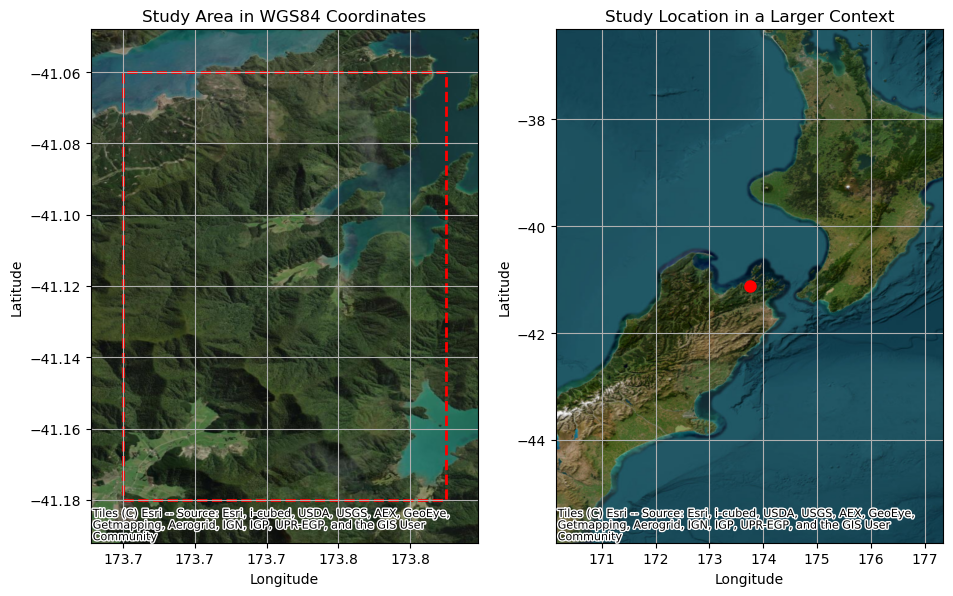

In [4]:
STUDY_SW = (173.7, -41.18)   # Using WGS84, intuitive and easily obtainable from Google Maps, geojson.io etc
STUDY_NE = (173.79, -41.06)
H_BUFFER = 0.1  #Extra space around the study displayed in maps as a fraction of the height
W_BUFFER = 0.1
CONTEXT_SCALE = 40  # Relative size of a second map showing a larger area for context

study_width_deg =  STUDY_NE[0] - STUDY_SW[0]
study_height_deg = STUDY_NE[1] - STUDY_SW[1]

h_buffer_deg = H_BUFFER * study_height_deg
w_buffer_deg = W_BUFFER * study_width_deg

map_sw = (STUDY_SW[0] - w_buffer_deg, STUDY_SW[1] - h_buffer_deg)
map_ne = (STUDY_NE[0] + w_buffer_deg, STUDY_NE[1] + h_buffer_deg)

map_width_deg =  map_ne[0] - map_sw[0]
map_height_deg = map_ne[1] - map_sw[1]

centre_longitude = (map_sw[0] + map_ne[0]) / 2  # Center longitude (average of SW and NE)
centre_latitude = (map_sw[1] + map_ne[1]) / 2   # Center latitude (average of SW and NE)

context_ne = (centre_longitude + study_width_deg * CONTEXT_SCALE,
              centre_latitude + study_height_deg * CONTEXT_SCALE)
context_sw = (centre_longitude - study_width_deg * CONTEXT_SCALE,
              centre_latitude - study_height_deg * CONTEXT_SCALE)

FIGURE_WIDTH = 5
FIGURE_HEIGHT = FIGURE_WIDTH *  map_height_deg / map_width_deg
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*FIGURE_WIDTH + 1, FIGURE_HEIGHT))

rectangle = plt.Rectangle((STUDY_SW),           #(x_min, y_min), width, height
                            study_width_deg, 
                            study_height_deg, 
                            linewidth=2, 
                            edgecolor='red', 
                            facecolor='none',
                            linestyle='--')

ax1.add_patch(rectangle)
ax1.set_xlim(map_sw[0], map_ne[0])
ax1.set_ylim(map_sw[1], map_ne[1])
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.set_title("Study Area in WGS84 Coordinates")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.grid(True)
ctx.add_basemap(ax1, crs="EPSG:4326", source=ctx.providers.Esri.WorldImagery)

ax2.plot(centre_longitude, centre_latitude, 'ro', markersize=8) 
ax2.set_xlim(context_sw[0], context_ne[0])
ax2.set_ylim(context_sw[1], context_ne[1])
ax2.set_title("Study Location in a Larger Context")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.grid(True)
ctx.add_basemap(ax2, crs="EPSG:4326", source=ctx.providers.Esri.WorldImagery)

plt.show()

Once we're happy with this, let's reproject those limits to NZTM2000 for the rest of our work.

In [5]:
map_cfg = MapSettings(input_system=4326,
                      map_projection=2193,
                      sw_corner=STUDY_SW,
                      ne_corner=STUDY_NE,
                      buffer=(W_BUFFER, H_BUFFER)
                      )

The original study area was specified in EPSG:4326
The map will be in projected coordinates using EPSG:2193


Now let's take a look at the data we're provided with

In [6]:
in_df = pd.read_csv(paths.WEKA_POINTS)
geometry = [Point(xy) for xy in zip(in_df['Easting'], in_df['Northing'])]
gdf = gpd.GeoDataFrame(in_df, geometry=geometry)
gdf.set_crs(epsg=map_cfg.EPSG, inplace=True)
input_length = gdf.length
gdf.head()

,Metal band,AgeClass,RDate,Territory,Easting,Northing,Apparent sex,RTime,LocationName,Area,Alive,geometry
0,M-81114,NaN,2011-12-13,NaN,1664541.0,5448992.0,male,NaN,NaN,Duncan Bay non-treatment,True,POINT (1664541 5448992)
1,M-81109,Adult,2010-09-23,Back yard of 207 Duncan Bay Rd,1664026.0,5447704.0,male,15:00:00,NaN,Duncan Bay non-treatment,True,POINT (1664026 5447704)
2,M-81109,Adult,2010-12-01,NaN,1664224.0,5447831.0,male,11:00:00,NaN,Duncan Bay non-treatment,True,POINT (1664224 5447831)
3,M-81109,NaN,2011-11-15,NaN,1664026.0,5447764.0,NaN,8:00:00,Back Yard,Duncan Bay non-treatment,True,POINT (1664026 5447764)
4,M-81110,Adult,2010-09-23,Back yard of 207 Duncan Bay Rd,1664026.0,5447704.0,female,14:10:00,NaN,Duncan Bay non-treatment,True,POINT (1664026 5447704)


In [7]:
indices_in_study = gdf.cx[map_cfg.study_sw[0]:map_cfg.study_ne[0], 
                          map_cfg.study_sw[1]:map_cfg.study_ne[1]].index
gdf['in_study'] = gdf.index.isin(indices_in_study)
gdf['is_empty'] = gdf['geometry'].is_empty
gdf['is_valid'] = gdf.geometry.is_valid
num_out_of_bounds = len(gdf[(gdf['in_study']==False) & (gdf['is_empty']==False)])
print(Colour.S + f"There are {len(gdf[gdf['in_study']==False])} rows with empty or out-of-study geometries" + Colour.E)
print(Colour.S + f"There are {num_out_of_bounds} rows with valid geometries but falling outside the study area" + Colour.E)

There are 277 rows with empty or out-of-study geometries
There are 7 rows with valid geometries but falling outside the study area


So we have a bunch rows with empty points.  Let's plot the rest, and see what's wrong with them.

In [8]:
gdf[(gdf['in_study']==False) & (gdf['is_empty']==False)]

,Metal band,AgeClass,RDate,Territory,Easting,Northing,Apparent sex,RTime,LocationName,Area,Alive,geometry,in_study,is_empty,is_valid
40,M-81116,Adult,2011-10-12,Harvey peninsula,1663729.0,4559218.0,male,10:23:00,NaN,Duncan Bay non-treatment,True,POINT (1663729 4559218),False,False,True
242,V-1201,Adult,2013-10-02,Opuri Saddle,5445522.0,5445522.0,female,12:40:00,NaN,Duncan Bay non-treatment,True,POINT (5445522 5445522),False,False,True
267,M-91311,Adult,2012-09-18,Campground,1662416.0,54447657.0,male,11:40:00,NaN,Duncan Bay non-treatment,True,POINT (1662416 54447657),False,False,True
312,M-91302,Adult,2012-10-04,NaN,1661116.0,1608195.0,male,15:00:00,NaN,Duncan Bay non-treatment,True,POINT (1661116 1608195),False,False,True
591,M-91318,NaN,2014-08-29,NaN,1659857.0,55443126.0,male,NaN,NaN,Duncan Bay non-treatment,True,POINT (1659857 55443126),False,False,True
596,V-0832,NaN,2013-09-03,NaN,16595021.0,5442992.0,female,NaN,NaN,Duncan Bay non-treatment,True,POINT (16595021 5442992),False,False,True
874,M-44455,NaN,2015-02-01,NaN,166187.0,5445507.0,NaN,NaN,NaN,Duncan Bay non-treatment,True,POINT (166187 5445507),False,False,True


Those all look like typos in their coodinates.  I'm going to filter them out for the remainder of this notebook.

In [9]:
gdf = gdf[(gdf['in_study']==True) & (gdf['is_empty']==False)]
gdf.to_file(paths.WEKA_GPKG)
print(Colour.S + f"Total number of recorded Weka sightings with valid locations: " + Colour.E + str(len(gdf)))
print(Colour.S + f"Unique metal band codes (individual birds) in this data: " + Colour.E + str(gdf['Metal band'].nunique()))

Total number of recorded Weka sightings with valid locations: 717
Unique metal band codes (individual birds) in this data: 102


Now let's plot and take a look interactively

In [10]:
gdf_wgs84 = gdf.to_crs(epsg=4326)
study_bounds = [[map_cfg.sw_deg[1],map_cfg.sw_deg[0]], # lat-long format, so [min_y, min_x , max_y, max_x]
                [map_cfg.ne_deg[1],map_cfg.ne_deg[0]]]  
fig_width = 500
fig_height = fig_width * (map_cfg.ne_deg[1]- map_cfg.sw_deg[1]) / (map_cfg.ne_deg[0] - map_cfg.sw_deg[0])

map = Map(center=(0, 0), 
          basemap =ctx.providers.Esri.WorldImagery,         
          layout={'height':f'{fig_height}px', 'width':f'{fig_width}px'},
          scroll_wheel_zoom=True)

standard_colors = [
    '#FF5733',  # Red
    '#33FF57',  # Green
    '#3357FF',  # Blue
    '#FF33A5',  # Pink
    '#000000',  # Black
    '#F3FF33',  # Yellow
    '#FF8C00',  # Dark Orange
    '#6A5ACD',  # Slate Blue
    '#FFD700',  # Gold
    '#FF4500'   # Orange Red
]
unique_bands = gdf['Metal band'].unique()
band_colors = {band: random.choice(standard_colors) for band in unique_bands}
gdf_wgs84['color'] = gdf_wgs84['Metal band'].map(band_colors)

rectangle = Rectangle(
    bounds=study_bounds,  # [[southwest], [northeast]] in lat,long (y,x)
    color='red',
    fill=False,
    stroke=True,
    weight=2
)

map.add(rectangle)

markers = []
for idx, row in gdf_wgs84.iterrows():
    circle_marker = CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=2,
        color=row.color,
        fill_color=row.color,
        fill_opacity=0.8
    )

    map.add(circle_marker)

map.fit_bounds(study_bounds)
map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

That looks nice.  It's interesting to see how much Weka mix and mingle with each other.  But anyway, now let's do some QGIS processing.

### QGIS Setup

In [11]:
QgsApplication.setPrefixPath(paths.QGIS_PREFIX, True)
from processing.core.Processing import processing

In [12]:
#We can't seem to run this cell more than once without re-starting the kernel first.
qgs = QgsApplication([], False)
qgs.initQgis()  
project = QgsProject.instance()
canvas = QgsMapCanvas()
map_crs = QgsCoordinateReferenceSystem(f'EPSG:{map_cfg.EPSG}')
project.read(paths.PROJECT_FILE)  
print(F'The QGIS project file will be located at: {project.fileName()}')

The QGIS project file will be located at: C:/Users/ollyp/OneDrive/Desktop/geoNotebooks/Working/weka_example_project.qgz


In [13]:
weka_pts_lyr = QgsVectorLayer(paths.WEKA_GPKG, "Weka Points", "ogr")
 
if weka_pts_lyr.isValid():
    QgsProject.instance().addMapLayer(weka_pts_lyr)
    print('Weka points added to the project'
    )
else:
    print("Layer failed to load!")
project.write(paths.PROJECT_FILE)


Weka points added to the project


True

In [14]:
project.addMapLayer(weka_pts_lyr)
canvas.setExtent(weka_pts_lyr.extent())
canvas.setLayers([weka_pts_lyr])
canvas.show()

This next step works to open a window from the QGIS app.  But this isn't what I want, I'd like to capture that image and show it in my notebook.  So there is an extra step needed here.

In [15]:
qgs.exec_()

0

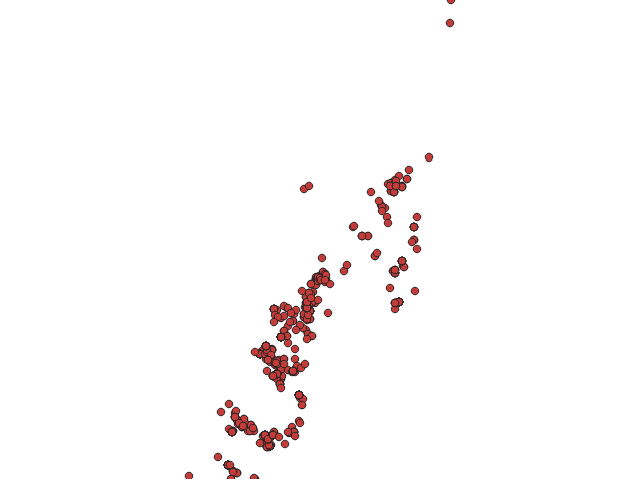

In [16]:
from PyQt5.QtGui import QImage, QPainter
from PyQt5.QtCore import QSize, QBuffer, QByteArray
from IPython.display import display
from PIL import Image
import io

def render_canvas_to_image(canvas):
    # Create an image object with the size of the canvas
    image = QImage(canvas.size(), QImage.Format_ARGB32_Premultiplied)
    
    # Create a QPainter object and paint the map canvas onto the image
    painter = QPainter(image)
    canvas.render(painter)
    painter.end()  # End the painting

    # Convert the QImage to bytes via QBuffer
    byte_array = QByteArray()
    buffer = QBuffer(byte_array)
    buffer.open(QBuffer.WriteOnly)
    image.save(buffer, 'PNG')  # Save the image to the buffer in PNG format
    buffer.close()

    # Convert the QByteArray to an in-memory bytes buffer for PIL
    image_bytes = io.BytesIO(byte_array.data())
    pil_image = Image.open(image_bytes)
    return pil_image

canvas.setLayers([weka_pts_lyr])
canvas.refresh()
img = render_canvas_to_image(canvas)
img.save("C:/Users/ollyp/OneDrive/Desktop/geoNotebooks/output_map.png")
display(img)

That's a bit messy, and I want to work with layouts eventually.  So let's try this with a layout manager, & QGIS layout export methods.

In [17]:
qgs.exit()

In [18]:
print('\033[1m' + '\033[94m' + "God damn it Gump you're goddamn genius. \n"
      "That's the most outstanding answer I've ever heard.\n"
      "You must have a goddam IQ of 160.\n"
      "You are goddam gifted private Gump." + '\033[0m')

God damn it Gump you're goddamn genius. 
That's the most outstanding answer I've ever heard.
You must have a goddam IQ of 160.
You are goddam gifted private Gump.
